In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction import text
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

# Set up training and test data
from sklearn.model_selection import train_test_split

path = '~/Desktop/UW- Internship 2020/dssg-disinfo/notebooks/data/'

df = pd.read_csv(path+'df_article_text.csv', sep=',')

df_neg = df[df['label'] == 0]
df_pos = df[df['label'] == 1]

# df_neg has less number of cases. Selecting same number of rows from df_pos
df_pos_sample = df_pos.sample(n = len(df_neg), random_state = 0)

df_balanced = pd.concat([df_pos_sample, df_neg], ignore_index=True)

X = df_balanced['article_text']
y = df_balanced['label']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

stop_words = text.ENGLISH_STOP_WORDS.union(['people', 'said', 'time', 'coronavirus', 'COVID', 'Audio'])

pipeline = Pipeline([('count_vectorizer', CountVectorizer(min_df = 0.1,
                                                         ngram_range= (1,3),
                                                         stop_words=stop_words,
                                                         lowercase = True)),
                     ('rf', RandomForestClassifier())])

param = {'rf__n_estimators': [10, 20, 30, 50, 100]}

randomized_pipe = RandomizedSearchCV(estimator = pipeline, 
                                         param_distributions=param, 
                                         cv=3, n_iter=30, n_jobs=-1)

rf_model = randomized_pipe.fit(X_train, y_train)

print('The model score with test data: ', rf_model.score(X_test, y_test))

# collect the individual steps
rf_step = randomized_pipe.best_estimator_.named_steps['rf']
count_vectorizer_step = randomized_pipe.best_estimator_.named_steps['count_vectorizer']

/Users/rashmigupta/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 5 is smaller than n_iter=30. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/rashmigupta/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['audio', 'covid'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


The model score with test data:  0.824396782841823


In [24]:
# data frame for the feature coefficients
df_coef = pd.DataFrame(rf_step.feature_importances_)

# data frame of feature names
df_features = pd.DataFrame(count_vectorizer_step.get_feature_names())
#df_features = df_features.transpose()

df_coef_feature_names = pd.concat((df_features, df_coef), axis =1, ignore_index=True)
#df_coef_feature_names = df_coef_feature_names.transpose()
df_coef_feature_names = df_coef_feature_names.sort_values(by=[1], ascending=False)

In [31]:
df_coef_feature_names.head(n = 10)

,0,1
169,covid,0.026353
170,covid 19,0.021652
11,19,0.017775
426,mask,0.015065
248,face,0.011720
367,june,0.011598
407,lockdown,0.011273
661,states,0.011214
427,masks,0.009838
342,india,0.009016


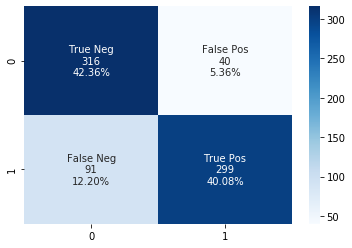

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate predictions with the model using our X values
y_pred = rf_model.predict(X_test)

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')